In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(1, r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning')

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from iminuit import Minuit
import FunctionCollection as fc
import importlib
import quadpy
from scipy.special import erf
from scipy.integrate import quad_vec
import sympy
fc = importlib.reload(fc)
from tqdm import tqdm
from scipy.stats import norm
import time

In [2]:
plt.rcParams.update({'font.size': 15})

In [3]:
pred_path = r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\predictions'

csv_list = [
            'OscNext_Angle_m27_23ge_test_predictions.csv',
#             'OscNext_Angle_m27_bothvMF_1qir_test_predictions.csv',
            'OscNext_Angle_m27_bothvMF2_vcqh_test_predictions.csv',
            'OscNext_Angle_m27_2xPvM_sylf_test_predictions.csv',
            'OscNext_Angle_m27_MEa_fcgf_test_predictions.csv',
            'OscNext_Angle_m27_vG2_2jnn_test_predictions.csv'
]

labels = ['SvM','SvM/2xPvM','2xPvM','MSE+MAE','vG']
colors = ['r','g','magenta','b','orange']

In [4]:
df_truth = pd.read_csv(os.path.join(pred_path,'OscNext_Angle_m27_23ge_test_predictions.csv'))[['event_no','azimuth','zenith','energy_log10','pid','elasticity']]

In [5]:
# def vec_to_angle_transform(df):
#     cos_az = np.cos(torch.tensor(df.azimuth)).unsqueeze(1)
#     sin_az = np.sin(torch.tensor(df.azimuth)).unsqueeze(1)
#     cos_ze = np.cos(torch.tensor(df.zenith)).unsqueeze(1)
#     sin_ze = np.sin(torch.tensor(df.zenith)).unsqueeze(1)
#     return torch.cat([cos_az*sin_ze, sin_az*sin_ze, cos_ze],dim=1)

def preprocess(df):
    cols = df.columns
    if 'x_pred' in cols:
        r = np.sqrt(df.x_pred**2 + df.y_pred**2 + df.z_pred**2)
#         fig, ax = plt.subplots()
#         ax.hist(r,bins=100)
        df['azimuth_pred'] = np.arctan2(df.y_pred,df.x_pred)
        df['zenith_pred'] = np.arccos(df.z_pred/r)
    if 'k_solid' in cols:
        kappa = df.k_solid**2 + 1e-5
        df['solid_sigma'] = np.sqrt(-2*np.log((1 + np.exp(-2*kappa))/(1 - np.exp(-2*kappa)) - 1/kappa))
    if 'k_az' in cols:
        from scipy.special import iv
        kappa =  df.k_az**2 + 1e-5
        df['azimuth_sigma'] = np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa)))
    if 'k_ze' in cols:
        from scipy.special import iv
        kappa =  df.k_ze**2 + 1e-5
        df['zenith_sigma'] = np.sqrt(-2*np.log(iv(1,kappa)/iv(0,kappa)))
    if 'pred_sigma' in  cols:
        df.rename(columns={'pred_sigma':'solid_sigma'},inplace=True)
    if 'solid' not in cols:
        def Omega(azp,zep,azt,zet):
            s1 = np.sin( zet + azt - azp )
            s2 = np.sin( zet - azt + azp )
            c1 = np.cos( zet - zep )
            c2 = np.cos( zet + zep )
            return np.arccos(0.5*np.abs(np.sin(zep))*( s1 + s2 ) + 0.5*(c1 + c2))
        df['solid'] = Omega(df.azimuth_pred,df.zenith_pred,df_truth.azimuth,df_truth.zenith)
    cols = df.columns
    return df.iloc[:,cols.isin(['solid','azimuth_pred','zenith_pred','solid_sigma','azimuth_sigma','zenith_sigma'])]

In [6]:
df_dict = dict()
for csv, label in tqdm(zip(csv_list,labels)):
    df_dict[label] = preprocess(pd.read_csv(os.path.join(pred_path,csv)))

5it [00:25,  5.19s/it]


The correlation in zenith suggests that the df's are lined up correctly


<Figure size 432x288 with 0 Axes>

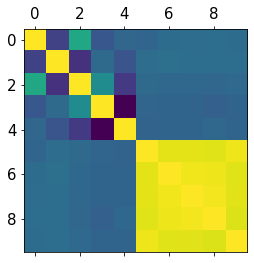

In [7]:
tmp = []
for df in df_dict.values():
    tmp.append(df[['azimuth_pred','zenith_pred']])

plt.figure()
plt.matshow(pd.concat(tmp,axis=1).iloc[:,[0,2,4,6,8,1,3,5,7,9]].corr())
del tmp
print("The correlation in zenith suggests that the df's are lined up correctly")

In [28]:
def binc(bine):
    return 0.5*(bine[1:] + bine[:-1])

# Plot 1

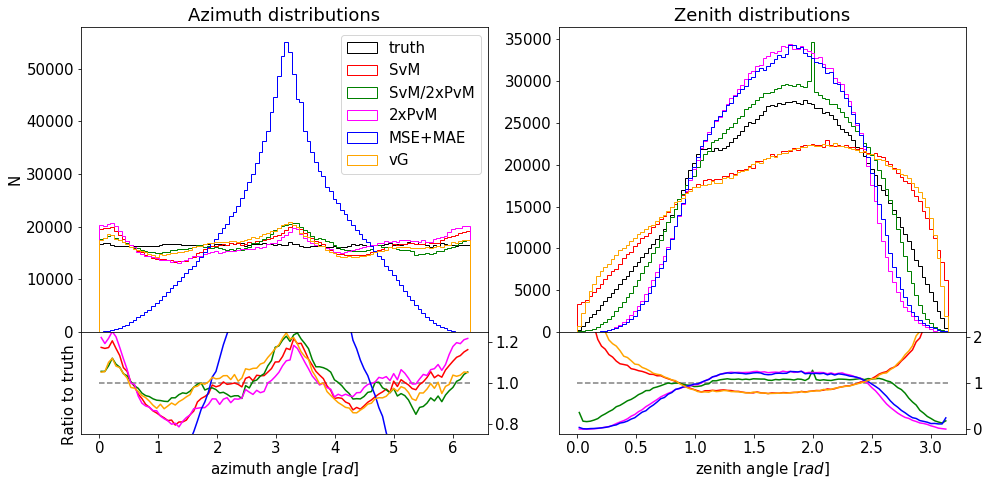

In [93]:
# fig, ax = plt.subplots(figsize=(14,7),ncols=2,nrows=2)
# ax = ax.flatten()
fig = plt.figure(figsize=(14,7))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(4,2,hspace=0)

ax = []
ax.append(fig.add_subplot(gs[:3,0]))
ax.append(fig.add_subplot(gs[:3,1]))
ax.append(fig.add_subplot(gs[3,0],sharex=ax[0]))
ax.append(fig.add_subplot(gs[3,1],sharex=ax[1]))
# ax.append(gs1[1,0])
# ax.append(gs1[1,1])
# ax.append(gs1[0,1])


val_azt, bine_azt, _ = ax[0].hist(df_truth.azimuth,bins=100,range=(0,2*np.pi),label='truth',color='k',histtype='step');
val_zet, bine_zet, _ = ax[1].hist(df_truth.zenith,bins=100,range=(0,np.pi),label='truth',color='k',histtype='step');


for x, label, color in zip([df.azimuth_pred for df in df_dict.values()],labels,colors):
    vals, bine, _ = ax[0].hist(x%(2*np.pi),bins=100,range=(0,2*np.pi),label=label,color=color,histtype='step');
    ax[2].plot(binc(bine),vals/val_azt,label=label,color=color)
    
for x, label, color in zip([df.zenith_pred for df in df_dict.values()],labels,colors):
    vals, bine, _ = ax[1].hist(np.abs(x),bins=100,range=(0,np.pi),label=label,color=color,histtype='step');
    ax[3].plot(binc(bine),vals/val_zet,label=label,color=color)

ax[2].set_ylim(0.75,1.25)
ax[3].set_ylim(-0.1,2.1)
ax[2].hlines(1,0,2*np.pi,color='k',ls='--',zorder=-1,alpha=0.5)
ax[3].hlines(1,0,1*np.pi,color='k',ls='--',zorder=-1,alpha=0.5)

# plt.setp(ax[0].get_xticklabels(), visible=False)
# plt.setp(ax[0].get_xticks(), visible=False)
# ax[0].set_xticklabels([])
ax[2].yaxis.tick_right()
ax[3].yaxis.tick_right()

ax[0].set(title='Azimuth distributions',ylabel='N')
ax[1].set(title='Zenith distributions')
ax[2].set(ylabel='Ratio to truth     ',xlabel='azimuth angle $[rad]$')
ax[3].set(xlabel='zenith angle $[rad]$')
    
ax[0].legend()
# ax[1].legend()
fig.tight_layout()

In [94]:
# fig.savefig('plots/loss_comparison_distributions.pdf')

# plot 2

In [212]:
def plot_quantiles(res, x, bins, qs, ax, label, color,offset):
    slices = np.linspace(x.min(),x.max(),bins + 1)
    quantiles = np.zeros((bins,len(qs)))
    xes = np.zeros(bins)
    
    for i in range(bins):
        mask = (x >= slices[i])&(x <= slices[i+1])
        quantiles[i] = np.quantile(res[mask],qs)
        xes[i] = np.mean(x[mask])
    
    xes += offset
    
    ax.errorbar(x = xes, y = quantiles[:,1], yerr = abs(quantiles[:,1] - quantiles[:,[0,2]].T),
                color=color,
                linewidth=5,
                alpha=0.5,
                capsize=5,
                linestyle='--',
                fmt='none')
    
    ax.plot(xes,quantiles[:,1],c=color,marker='*',label=label)
#     plt.grid()
    
    ax_hist = ax.twinx()
    val, binedges, _ = ax_hist.hist(x,bins=bins,histtype='step',color='grey',linewidth=5)
    ax_hist.vlines(xes-offset,val+0.1*val.mean(),val-0.1*val.mean(),color='grey',label='mean')
    ax_hist.set_ylim(0,ax_hist.get_ylim()[1])
    ax_hist.set_ylabel("N")
#     ax_hist.set_yscale('log')
    ax.set_zorder(ax_hist.get_zorder()+1)
    ax.patch.set_visible(False)
    
#     fig.show()

Text(0, 0.5, '$16^{th}$-$50^{th}$-$68^{th}$ percentile of the solid angle $[deg]$')

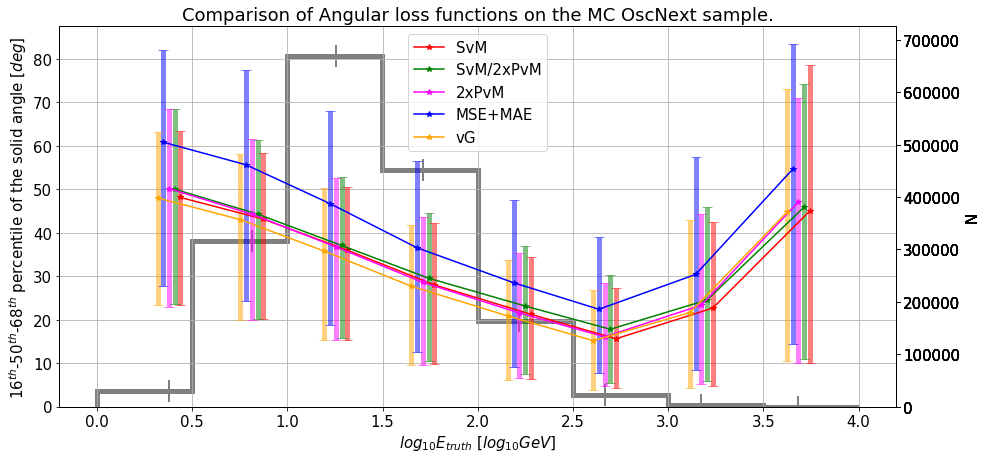

In [213]:
fig, ax = plt.subplots(figsize=(15,7))
# plt.yscale('log')
plt.grid()

for i, (x, label, color) in enumerate(zip([df.solid for df in df_dict.values()],labels,colors)):
    offset = 0.03*(len(df_list)/2 - i - 0.5)
    plot_quantiles(x*180/np.pi,df_truth.energy_log10,8,[0.16,0.5,0.68],ax,label,color,offset)

ax.legend()
ax.set_title("Comparison of Angular loss functions on the MC OscNext sample.")
ax.set_xlabel("$log_{10}E_{truth}$ $[log_{10}GeV]$")
ax.set_ylabel("$16^{th}$-$50^{th}$-$68^{th}$ percentile of the solid angle $[deg]$")

In [214]:
# fig.savefig("plots/angular_loss_comparison.pdf")

# (pending) plot 3

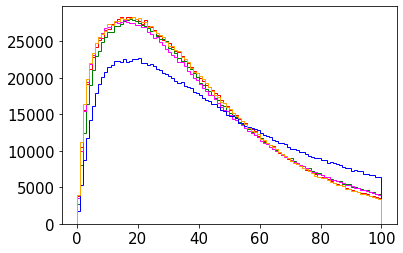

In [215]:
fig, ax = plt.subplots()

for i, (x, label, color) in enumerate(zip([df.solid for df in df_dict.values()],labels,colors)):
    ax.hist(x*180/np.pi,bins=100,range=(0,100),histtype='step',color=color,label=label);
# ax.set_xscale('log')

In [231]:
color_dict = dict(zip(labels,colors))

C:\Users\jv97\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jv97\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\jv97\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jv97\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


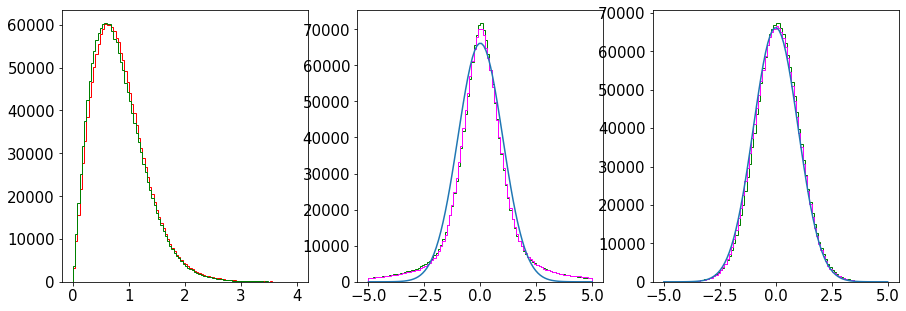

In [248]:
def plot_Z(res,sig,ax,bins,range,label,color):
    ax.hist(res/sig,bins=bins,range=range,label=label,color=color,histtype='step')

fig, ax = plt.subplots(figsize=(15,5),ncols=3)

for key in ['SvM','SvM/2xPvM']:
    df = df_dict[key]
    plot_Z(df.solid,df.solid_sigma,ax[0],100,(0,4),key,color_dict[key])
    

for key in ['SvM/2xPvM','2xPvM']:
    df = df_dict[key]
    plot_Z((df.azimuth_pred%(2*np.pi) - df_truth.azimuth),df.azimuth_sigma,ax[1],100,(-5,5),key,color_dict[key])
    plot_Z((df.zenith_pred.abs() - df_truth.zenith),df.zenith_sigma,ax[2],100,(-5,5),key,color_dict[key])

ax[1].plot(np.linspace(-5,5,100),norm.pdf(np.linspace(-5,5,100))*df_truth.__len__()/10)
ax[2].plot(np.linspace(-5,5,100),norm.pdf(np.linspace(-5,5,100))*df_truth.__len__()/10)

# (pending) plot 4

In [47]:
# def transform_daz(daz):
#     mask = daz > np.pi
#     daz[mask] = 2*np.pi - daz[mask]
#     mask = daz < -np.pi
#     daz[mask] = daz[mask]%np.pi
#     return daz
def transform_daz(daz):
    return np.arccos(np.cos(daz))

transform_daz(2*np.pi*np.array([0.9-0.1,0.3-0.9,0.5-0.6,-1.5-0.1]))/(2*np.pi)

array([0.2, 0.4, 0.1, 0.4])

In [186]:
from tqdm import tqdm

N = 50
subsample = 100000

d = (df_truth.azimuth.max() - df_truth.azimuth.min())/N
azs = np.arange(0,df_truth.azimuth.max()+d,d)
zes = np.arange(0,df_truth.zenith.max()+d/2,d/2)

def transform_daz(daz):
    mask = daz > np.pi
    daz[mask] = 2*np.pi - daz[mask]
    mask = daz < -np.pi
    daz[mask] = daz[mask]%np.pi
    return daz


h = np.zeros((len(labels),azs.shape[0],zes.shape[0]))
for i, df in enumerate(df_dict.values()):
    for row, az in enumerate(tqdm(azs)):
        for col, ze in enumerate(zes):
#             r = ((transform_daz(df.azimuth_pred.iloc[:subsample] - az))**2 + (df.zenith_pred.iloc[:subsample] - ze)**2)
#             w = (1+r/d**2)**(-2)#np.exp(-2/d*r)
#             h[i,row,col] = (w*df.solid.iloc[:subsample]).sum()/w.sum()

            daz = transform_daz(df.azimuth_pred.iloc[:subsample] - az)
            dze = df.zenith_pred.iloc[:subsample] - ze
            h[i,row,col] = df.iloc[:subsample].solid[(np.abs(daz)<d)&(np.abs(dze)<d)].mean()



  0%|                                                   | 0/52 [00:00<?, ?it/s]

  2%|▊                                          | 1/52 [00:00<00:45,  1.12it/s]

  4%|█▋                                         | 2/52 [00:01<00:44,  1.11it/s]

  6%|██▍                                        | 3/52 [00:02<00:43,  1.12it/s]

  8%|███▎                                       | 4/52 [00:03<00:42,  1.14it/s]

 10%|████▏                                      | 5/52 [00:04<00:41,  1.13it/s]

 12%|████▉                                      | 6/52 [00:05<00:41,  1.10it/s]

 13%|█████▊                                     | 7/52 [00:06<00:40,  1.10it/s]

 15%|██████▌                                    | 8/52 [00:07<00:39,  1.10it/s]

 17%|███████▍                                   | 9/52 [00:08<00:39,  1.10it/s]

 19%|████████                                  | 10/52 [00:09<00:38,  1.10it/s]

 21%|████████▉                                 | 11/52 [00:09<00:37,  1.09it/s]

 23%|█████████▋           

KeyboardInterrupt: 

In [361]:
np.linspace(0,2*np.pi*(1-1/10),10), 2*np.pi - (5.65486678 - 5.02654825)

(array([0.        , 0.62831853, 1.25663706, 1.88495559, 2.51327412,
        3.14159265, 3.76991118, 4.39822972, 5.02654825, 5.65486678]),
 5.654866777179587)

In [396]:
for df in df_dict.values():
    print(df.zenith_pred.abs().max())

3.9344216060638435
3.2085039091110232
3.1989871931076053
3.338118553161621
3.140221655276608


In [407]:
def transform_ze(ze):
    ze = np.abs(ze)
    mask = ze>np.pi
    ze[mask] = np.pi - ze[mask]%np.pi
    return ze

transform_ze(np.pi*np.array([1.1,-0.1,1,0,0.5,3.5]))/np.pi
    

array([0.9, 0.1, 1. , 0. , 0.5, 0.5])

In [434]:
v_azs[1:] - v_azs[:-1], 2*np.pi/(N-1), v_zes[1:] - v_zes[:-1], (np.pi-2*ze_offset)/(N-1)

(array([0.6981317, 0.6981317, 0.6981317, 0.6981317, 0.6981317, 0.6981317,
        0.6981317, 0.6981317, 0.6981317]),
 0.6981317007977318,
 array([0.23736482, 0.23736482, 0.23736482, 0.23736482, 0.23736482,
        0.23736482, 0.23736482, 0.23736482, 0.23736482]),
 0.23736481556588707)

In [475]:
daz = transform_daz(df_truth.iloc[:subsample].azimuth - v_azs[0])
dze = df_truth.iloc[:subsample].zenith - v_zes[0]
        
mask = (np.abs(daz)<2*np.pi/(N-1)/2)&(np.abs(dze)<(np.pi-2*ze_offset)/(N-1)/2)

In [476]:
sample = df.iloc[:subsample][mask]
np.quantile(transform_ze(sample.zenith_pred) - df_truth.iloc[:subsample][mask].zenith,0.5)

0.18422458588640023

In [456]:
np.arange(subsample)[mask]

array([35294, 36681, 37028, 37089, 39560, 40577, 41360, 42083, 43173,
       43814, 44225, 44827, 45986, 47408, 47734, 56446, 56603, 58339,
       58683, 60256, 63726, 66387, 68207, 68414, 69573, 69981, 71339,
       71844, 77496, 78527, 79226, 80168, 82639, 88997, 94974])

In [478]:
v[0,0]

array([[-0.07375875, -0.01860914,  0.02459122,  0.06486376, -0.02126281,
         0.02823218, -0.01967213, -0.00861418,  0.01530292,  0.02785212],
       [ 0.9782327 ,  0.62107854,  0.39981211,  0.37782688,  0.4706878 ,
         0.4271329 ,  0.47259666,  0.53008454,  0.71037514,  0.90497964],
       [ 0.60142242,  0.37173341,  0.15413149,  0.15490847,  0.24604251,
         0.21735134,  0.2863932 ,  0.25879635,  0.38520569,  0.40734757],
       [ 0.34315033,  0.17742903,  0.06998829,  0.11109997,  0.17443037,
         0.19860799,  0.13704059,  0.15126609,  0.21518674,  0.31056192],
       [ 0.20403657,  0.08893425, -0.00984092,  0.01835771,  0.0860443 ,
         0.06096781,  0.0252305 ,  0.05511897,  0.09435296,  0.06584177],
       [-0.0782536 , -0.05635216, -0.00975593, -0.01259797, -0.11789591,
        -0.04591839, -0.06268191, -0.02770371, -0.07099076, -0.07467728],
       [-0.12392273, -0.01466869,  0.04897048, -0.02866911, -0.10308873,
        -0.05940139, -0.08185456, -0.12477749

In [63]:
def bine(binc):
    d = (binc[1:] - binc[:-1]).mean()
    assert (binc[1:] - binc[:-1]).std() < 1e-15, "the std(width) is larger than 1e-15"
    return np.append(binc-d/2,binc[-1]+d/2)

def transform_ze(ze):
    ze = np.abs(ze)
    mask = ze>np.pi
    ze[mask] = np.pi - ze[mask]%np.pi
    return ze

array([[ 2528.,  7567., 13596., 21427., 24296., 26893., 26519., 22196.,
        14724.,  5352.],
       [ 2446.,  7720., 13468., 20404., 23991., 27294., 26708., 22603.,
        14966.,  5222.],
       [ 2402.,  7587., 13903., 20818., 24214., 27458., 27089., 22719.,
        15031.,  5260.],
       [ 2502.,  7768., 13670., 20884., 24515., 27674., 26776., 22816.,
        15037.,  5233.],
       [ 2412.,  7555., 13912., 20982., 24601., 27517., 27178., 22583.,
        15045.,  5214.],
       [ 2532.,  7549., 13373., 20408., 24289., 27256., 26998., 22464.,
        14843.,  5282.],
       [ 2471.,  7490., 13384., 20715., 23718., 26947., 26258., 22089.,
        14855.,  5313.],
       [ 2440.,  7512., 14452., 22397., 23914., 26785., 26364., 21957.,
        14832.,  5301.],
       [ 2524.,  7601., 14958., 23497., 23901., 26950., 26539., 22117.,
        14733.,  5103.],
       [ 2490.,  7633., 14001., 22244., 24091., 26940., 26305., 22194.,
        14834.,  5244.]])

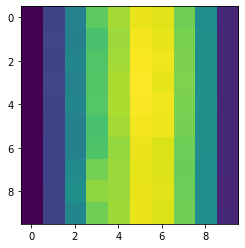

In [504]:
vals, binex, biney = np.histogram2d(df_truth.azimuth,df_truth.zenith)
plt.figure()
plt.imshow(vals)
vals

In [16]:
df_truth.iloc[:subsample].__len__()

1658362

In [28]:
np.abs(transform_daz(df_truth.iloc[:subsample].azimuth - az))<2*np.pi/(N-1)/2

0        False
1         True
2        False
3        False
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Name: azimuth, Length: 100000, dtype: bool

In [25]:
list1 = [1,2,3,4,5,6]
list2 = [3, 5, 7, 9]
list(set(list1).intersection(list2))

[3, 5]

In [38]:
df_truth.iloc[:subsample].index[np.abs(transform_daz(df_truth.iloc[:subsample].azimuth - az))<2*np.pi/(N-1)/2].tolist()

2266

In [43]:
N = 50
subsample = None

azs = np.linspace(0,2*np.pi,N)
ze_offset = 0.0*np.pi
zes = np.linspace(0+ze_offset,np.pi-ze_offset,N)

# az_mask = np.zeros((df_truth.iloc[:subsample].__len__(),azs.shape[0]))
# ze_mask = np.zeros((df_truth.iloc[:subsample].__len__(),zes.shape[0]))

az_mask = []
ze_mask = []

for i, az in enumerate(azs):
#     az_mask[:,i] = np.abs(transform_daz(df_truth.iloc[:subsample].azimuth - az))<2*np.pi/(N-1)/2
    az_mask.append(df_truth.iloc[:subsample].index[np.abs(transform_daz(df_truth.iloc[:subsample].azimuth - az))<2*np.pi/(N-1)/2].tolist())

for i, ze in enumerate(tqdm(zes)):
#     ze_mask[:,i] = np.abs(df_truth.iloc[:subsample].zenith - ze)<(np.pi-2*ze_offset)/(N-1)/2
    ze_mask.append(df_truth.iloc[:subsample].index[np.abs(df_truth.iloc[:subsample].zenith - ze)<(np.pi-2*ze_offset)/(N-1)/2].tolist())

n = np.zeros((azs.shape[0],zes.shape[0]))
h = np.zeros((len(labels),zes.shape[0],azs.shape[0]))
for i, df in enumerate(df_dict.values()):
    for col, az in enumerate(tqdm(azs)):
        for row, ze in enumerate(zes):
#             start = time.time()
#             mask = az_mask[:,col]*ze_mask[:,row]
            mask = list(set(az_mask[col]).intersection(ze_mask[row]))
#             print(time.time() - start)
#             print("----------")
#             start = time.time()
            try:
#                 h[i,row,col] = np.quantile(df.iloc[:subsample].solid[mask],0.5)
                h[i,row,col] = np.quantile(df.iloc[:subsample].solid.iloc[mask],0.5)
            except:
                h[i,row,col] = None
#             print(time.time() - start)
            if i == 0:
#                 n[row,col] = mask.sum()
                n[row,col] = len(mask)
#     break

100%|██████████████████████████████████████████| 50/50 [00:09<00:00,  5.16it/s]


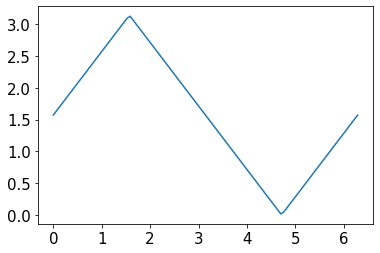

In [93]:
fig, ax = plt.subplots()
x = np.linspace(0,2*np.pi, num=100)

ax.plot(x,np.arccos(np.cos(x-1.5*np.pi)))

In [ ]:
def dev_az(sample, truth):
    

In [79]:
N = 10
v_azs = np.linspace(0,2*np.pi,N)
ze_offset = 0.1*np.pi
v_zes = np.linspace(0+ze_offset,np.pi-ze_offset,N)

v_az_mask = []
v_ze_mask = []

for i, az in enumerate(tqdm(v_azs)):
#     az_mask[:,i] = np.abs(transform_daz(df_truth.iloc[:subsample].azimuth - az))<2*np.pi/(N-1)/2
    v_az_mask.append(df_truth.iloc[:subsample].index[np.abs(transform_daz(df_truth.iloc[:subsample].azimuth - az))<2*np.pi/(N-1)/2].tolist())

for i, ze in enumerate(tqdm(v_zes)):
#     ze_mask[:,i] = np.abs(df_truth.iloc[:subsample].zenith - ze)<(np.pi-2*ze_offset)/(N-1)/2
    v_ze_mask.append(df_truth.iloc[:subsample].index[np.abs(df_truth.iloc[:subsample].zenith - ze)<(np.pi-2*ze_offset)/(N-1)/2].tolist())


v = np.zeros((len(labels),2,v_azs.shape[0],v_zes.shape[0]))
for i, df in enumerate(df_dict.values()):
    for col, az in enumerate(tqdm(v_azs)):
        for row, ze in enumerate(v_zes):
            mask = list(set(v_az_mask[col]).intersection(v_ze_mask[row]))
            sample = df.iloc[:subsample].iloc[mask]
            
            v[i,0,row,col] = np.quantile(sample.azimuth_pred%(2*np.pi) - df_truth.iloc[:subsample].iloc[mask].azimuth,0.5)
            v[i,1,row,col] = np.quantile(transform_ze(sample.zenith_pred) - df_truth.iloc[:subsample].iloc[mask].zenith,0.5)
#             v[i,0,row,col] = np.quantile(sample.azimuth_pred%(2*np.pi) - df_truth.iloc[:subsample][mask].azimuth,0.5)
#             v[i,1,row,col] = np.quantile(transform_ze(sample.zenith_pred) - df_truth.iloc[:subsample][mask].zenith,0.5)
#     break

100%|██████████████████████████████████████████| 10/10 [00:05<00:00,  1.96it/s]


In [569]:
# N = 50
# subsample = None

# azs = np.linspace(0,2*np.pi,N)
# ze_offset = 0.0*np.pi
# zes = np.linspace(0+ze_offset,np.pi-ze_offset,N)

# # truth_masks = np.zeros((df_truth.iloc[:subsample].__len__(),zes.shape[0],azs.shape[0]))
# # for col, az in enumerate(tqdm(azs)):
# #     daz = transform_daz(df_truth.iloc[:subsample].azimuth - az)
# #     for row, ze in enumerate(zes):
# #         dze = df_truth.iloc[:subsample].zenith - ze
# #         truth_masks[:,col,row] = (np.abs(daz)<2*np.pi/(N-1)/2)&(np.abs(dze)<(np.pi-2*ze_offset)/(N-1)/2)

# n = np.zeros((azs.shape[0],zes.shape[0]))
# h = np.zeros((len(labels),zes.shape[0],azs.shape[0]))
# for i, df in enumerate(df_dict.values()):
#     for row, ze in enumerate(tqdm(zes)):
#         dze = df_truth.iloc[:subsample].zenith - ze
#         for col, az in enumerate(azs):
#             daz = transform_daz(df_truth.iloc[:subsample].azimuth - az)
#             mask = (np.abs(daz)<2*np.pi/(N-1)/2)&(np.abs(dze)<(np.pi-2*ze_offset)/(N-1)/2)
#             try:
#                 h[i,row,col] = np.quantile(df.iloc[:subsample].solid[mask],0.5)
#             except:
#                 h[i,row,col] = None
#             if i == 0:
#                 n[row,col] = mask.sum()
#     break






  0%|                                                   | 0/50 [00:00<?, ?it/s]




  2%|▊                                          | 1/50 [00:09<08:02,  9.84s/it]




  4%|█▋                                         | 2/50 [00:19<07:47,  9.73s/it]




  6%|██▌                                        | 3/50 [00:28<07:32,  9.62s/it]




  8%|███▍                                       | 4/50 [00:38<07:19,  9.55s/it]




 10%|████▎                                      | 5/50 [00:47<07:04,  9.44s/it]




 12%|█████▏                                     | 6/50 [00:56<06:53,  9.41s/it]




 14%|██████                                     | 7/50 [01:05<06:40,  9.31s/it]




 16%|██████▉                                    | 8/50 [01:14<06:25,  9.19s/it]




 18%|███████▋                                   | 9/50 [01:24<06:25,  9.40s/it]




 20%|████████▍                                 | 10/50 [01:34<06:22,  9.57s/it]




 22%|█████████▏                                | 11/50 [01:43<06:07,  9

In [573]:
# N = 10
# v_azs = np.linspace(0,2*np.pi,N)
# ze_offset = 0.1*np.pi
# v_zes = np.linspace(0+ze_offset,np.pi-ze_offset,N)

# v = np.zeros((len(labels),2,v_azs.shape[0],v_zes.shape[0]))
# for i, df in enumerate(df_dict.values()):
#     for col, az in enumerate(tqdm(v_azs)):
#         daz = transform_daz(df_truth.iloc[:subsample].azimuth - az)
#         for row, ze in enumerate(v_zes):
#             dze = df_truth.iloc[:subsample].zenith - ze
        
#             mask = (np.abs(daz)<2*np.pi/(N-1)/2)&(np.abs(dze)<(np.pi-2*ze_offset)/(N-1)/2)
#             sample = df.iloc[:subsample][mask]

#             v[i,0,row,col] = np.quantile(sample.azimuth_pred%(2*np.pi) - df_truth.iloc[:subsample][mask].azimuth,0.5)
#             v[i,1,row,col] = np.quantile(transform_ze(sample.zenith_pred) - df_truth.iloc[:subsample][mask].zenith,0.5)
#     break






  0%|                                                   | 0/10 [00:00<?, ?it/s]




 10%|████▎                                      | 1/10 [00:00<00:06,  1.41it/s]




 20%|████████▌                                  | 2/10 [00:01<00:05,  1.48it/s]




 30%|████████████▉                              | 3/10 [00:01<00:04,  1.56it/s]




 40%|█████████████████▏                         | 4/10 [00:02<00:03,  1.65it/s]




 50%|█████████████████████▌                     | 5/10 [00:02<00:02,  1.74it/s]




 60%|█████████████████████████▊                 | 6/10 [00:03<00:02,  1.81it/s]




 70%|██████████████████████████████             | 7/10 [00:03<00:01,  1.83it/s]




 80%|██████████████████████████████████▍        | 8/10 [00:04<00:01,  1.81it/s]




 90%|██████████████████████████████████████▋    | 9/10 [00:05<00:00,  1.79it/s]




100%|██████████████████████████████████████████| 10/10 [00:05<00:00,  1.75it/s]


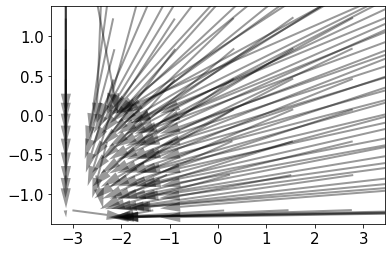

In [80]:
fig, ax = plt.subplots()
# ax.scatter(*np.meshgrid((v_azs-np.pi)*180/np.pi,(v_zes-np.pi/2)*180/np.pi),alpha=0.5)
ax.quiver(*np.meshgrid((v_azs-np.pi),(v_zes-np.pi/2)),v[0,0],v[0,1],color='k',zorder=10,alpha=0.4,scale=5,pivot='mid',headaxislength=10,headlength=10,headwidth=5)#,headlength=10,headwidth=5,minshaft=0.5)
# ax.quiver(0,0,10,10)

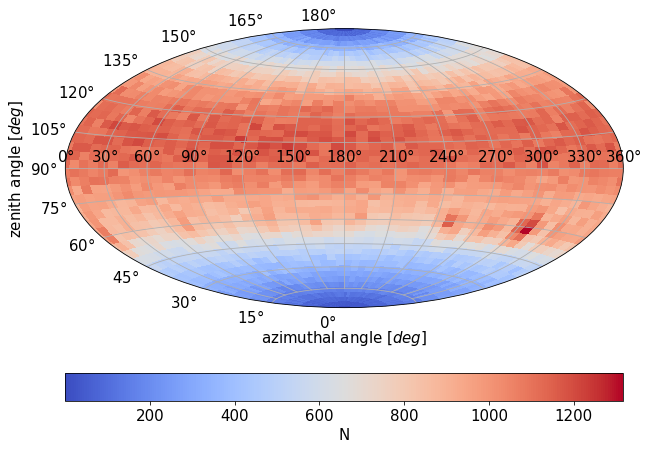

In [48]:
fig, ax = plt.subplots(subplot_kw=dict(projection='hammer'), figsize=(10,8))
im = ax.pcolormesh(*np.meshgrid((bine(azs)-np.pi),(bine(zes)-np.pi/2)),n,cmap='coolwarm')#For example,using as cmap="Spectral",cmap="seismic",cmap="coolwarm" as other alternatives
# ax.grid()
cbar = fig.colorbar(im, orientation='horizontal');

ax.grid()
ax.set(xlabel='azimuthal angle $[deg]$',ylabel='zenith angle $[deg]$')
ax.xaxis.labelpad = 20

yticks=np.arange(0,180+15,15)
ax.set_yticks((yticks-180/2)*np.pi/180)
ax.set_yticklabels([str(deg)+"$\degree$" for deg in yticks])

xticks = np.arange(0,360+30,30)
ax.set_xticks((xticks-180)*np.pi/180)
ax.set_xticklabels([str(deg)+"$\degree$" for deg in xticks])

# cbar = fig.colorbar(im, orientation='horizontal');
cbar.set_label("N")

In [647]:
fig.savefig("plots/NCorrWithAzZe.pdf")

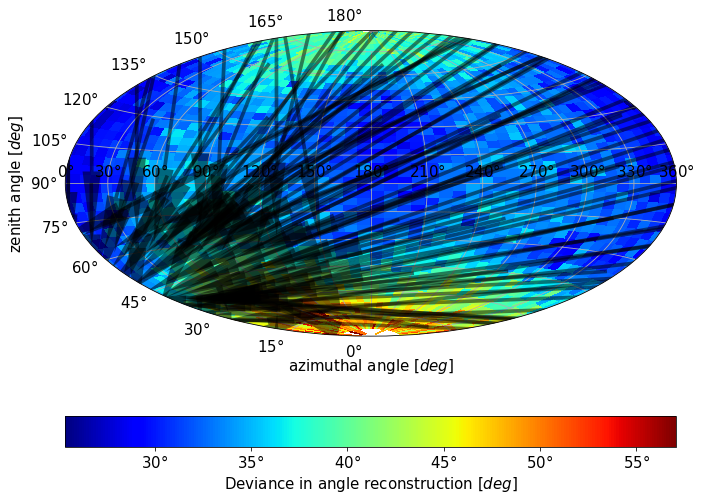

In [82]:
i = 2

fig, ax = plt.subplots(subplot_kw=dict(projection='hammer'), figsize=(10,8))
# im = ax.pcolormesh(*np.meshgrid((bine(azs)-np.pi),(bine(zes)-np.pi/2)),h[0]*180/np.pi,cmap='jet')#For example,using as cmap="Spectral",cmap="seismic",cmap="coolwarm" as other alternatives

X, Y = np.meshgrid((bine(azs)-np.pi),(bine(zes)-np.pi/2))
mask = n<50
tmp = h[i].copy()
tmp[mask] = None
im = ax.pcolormesh(X,Y,tmp*180/np.pi,cmap='jet')

ax.quiver(*np.meshgrid((v_azs-np.pi),(v_zes-np.pi/2)),v[i,0],v[i,1],color='k',zorder=10,alpha=0.5,scale=5,pivot='mid',headaxislength=20,headlength=20,headwidth=5)#,headlength=10,headwidth=5,minshaft=0.5)
# ax.quiver(0,0,0.5*np.pi,0.5*np.pi)

ax.grid()
ax.set(xlabel='azimuthal angle $[deg]$',ylabel='zenith angle $[deg]$')
ax.xaxis.labelpad = 20

yticks=np.arange(0,180+15,15)
ax.set_yticks((yticks-180/2)*np.pi/180)
ax.set_yticklabels([str(deg)+"$\degree$" for deg in yticks])

xticks = np.arange(0,360+30,30)
ax.set_xticks((xticks-180)*np.pi/180)
ax.set_xticklabels([str(deg)+"$\degree$" for deg in xticks])

cbar = fig.colorbar(im, orientation='horizontal');
cbar.set_label("Deviance in angle reconstruction $[deg]$")
# cbar.set_label("Deviance in angle reconstruction $[deg]$")

cbar.ax.set_xticklabels([str(int(deg))+"$\degree$" for deg in cbar.get_ticks()])

# fig.colorbar(im);
fig.tight_layout()

In [94]:
h.shape

(5, 50, 50)

In [635]:
cbar.get_ticks()

array([20., 25., 30., 35., 40.])

In [638]:
fig.savefig('plots/SolidCorrWithAzZe.pdf')

In [97]:
n.reshape(1,50,50).shape

(1, 50, 50)

In [102]:
X,Y=np.meshgrid(azs-np.pi,zes-np.pi/2)
tmp = np.concatenate([n.reshape(1,50,50),X.reshape(1,50,50),Y.reshape(1,50,50),h],axis=0)

In [103]:
# np.save('NAzZe_solidCorr_SvM_bothvM_2xPvM_MSEMAE_vG.npy',tmp)

In [99]:
# h[1] = n
X,Y=np.meshgrid(azs-np.pi,zes-np.pi/2)
# h[2] = X
# h[3] = Y

In [592]:
# np.save('SvM_solidCorrAzZe_solid_N_az_ze.npy',h[[0,1,2,3]])
# np.load('SvM_solidCorrAzZe_solid_N_az_ze.npy')

array([[[  0.48253565,   0.33884326,   0.39694434, ...,   0.43094547,
           0.81647569,   0.48253565],
        [  0.57195373,   0.45505027,   0.62271329, ...,   0.46847165,
           0.57853522,   0.57195373],
        [  0.43513521,   0.56552733,   0.57302249, ...,   0.45364312,
           0.49768888,   0.43513521],
        ...,
        [  0.313349  ,   0.3011715 ,   0.31329384, ...,   0.33274591,
           0.33264126,   0.313349  ],
        [  0.36853725,   0.27100565,   0.29884447, ...,   0.28640217,
           0.33711558,   0.36853725],
        [  0.41876948,   0.34821356,   0.35280765, ...,   0.67065035,
           0.52046532,   0.41876948]],

       [[  3.        ,   3.        ,   6.        , ...,   5.        ,
           6.        ,   3.        ],
        [ 48.        ,  58.        ,  51.        , ...,  45.        ,
          42.        ,  48.        ],
        [ 81.        ,  83.        ,  67.        , ...,  80.        ,
          79.        ,  81.        ],
        ...,


In [225]:
mask = (np.abs(daz)<d)&(np.abs(dze)<d)
sample = df_dict[labels[0]].iloc[:subsample][mask]

# fig, ax = plt.subplots()
# ax.scatter(transform_daz(sample.azimuth_pred - df_truth.azimuth), sample.zenith_pred - df_truth.zenith)
az_dev = np.quantile(transform_daz(sample.azimuth_pred%(2*np.pi) - df_truth.iloc[:subsample][mask].azimuth),0.5)
ze_dev = np.quantile(sample.zenith_pred - df_truth.iloc[:subsample][mask].zenith,0.5)

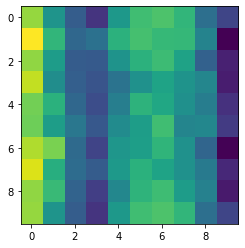

In [496]:
plt.figure()
plt.imshow(v[0,1])

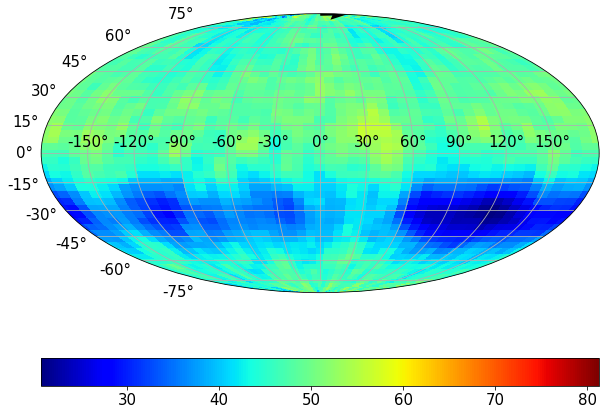

In [242]:
fig, ax = plt.subplots(subplot_kw=dict(projection='mollweide'), figsize=(10,8))
im = ax.pcolormesh(*np.meshgrid((bine(azs)-np.pi),(bine(zes)-np.pi/2)),h[0].T*180/np.pi,cmap='jet')#For example,using as cmap="Spectral",cmap="seismic",cmap="coolwarm" as other alternatives

ax.quiver(azs[-1]-np.pi,zes[-1]-np.pi/2,az_dev,ze_dev,zorder=10)

ax.grid()
fig.colorbar(im, orientation='horizontal');

[2.84341493e-03 3.16116796e-01 6.29390178e-01 9.42663559e-01
 1.25593694e+00 1.56921032e+00 1.88248370e+00 2.19575708e+00
 2.50903047e+00 2.82230385e+00 3.13557723e+00] 0.002843414929802545 3.135577228130607


C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\FunctionCollection.py:205: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\FunctionCollection.py:215: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


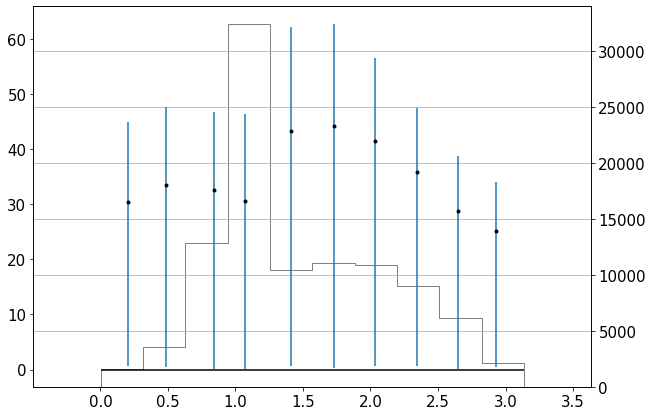

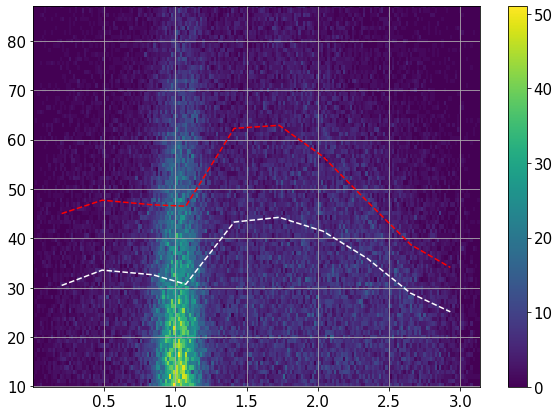

In [176]:
fc.performance_plot(df_dict[labels[0]].iloc[:subsample].solid*180/np.pi,df_truth.iloc[:subsample].zenith.values,bins=10,zero_bounded=True);

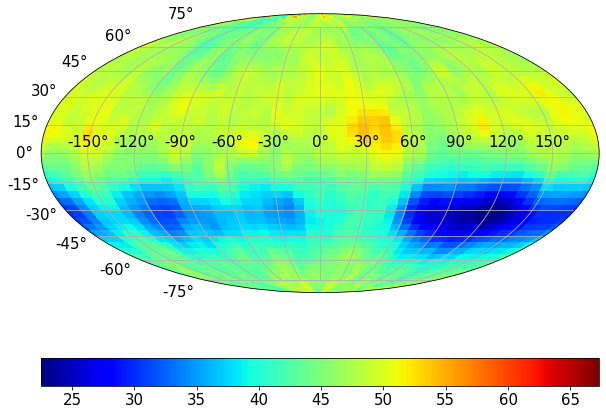

In [160]:
fig, ax = plt.subplots(subplot_kw=dict(projection='mollweide'), figsize=(10,8))
im = ax.pcolormesh(*np.meshgrid((bine(azs)-np.pi),(bine(zes)-np.pi/2)),h[0].T*180/np.pi,cmap='jet')#For example,using as cmap="Spectral",cmap="seismic",cmap="coolwarm" as other alternatives
ax.grid()
fig.colorbar(im, orientation='horizontal');

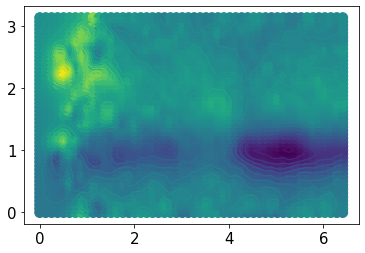

In [140]:
fig, ax = plt.subplots()
ax.scatter(*np.meshgrid(azs,zes),c=h[0].T,s=100)
ax.contour(*np.meshgrid(azs,zes),h[0].T,levels=20)

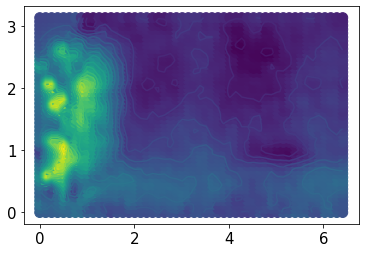

In [101]:
fig, ax = plt.subplots()
ax.scatter(*np.meshgrid(azs,zes),c=h[0].T,s=100)
ax.contour(*np.meshgrid(azs,zes),h[0].T,levels=20)

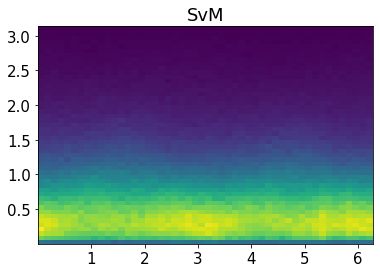

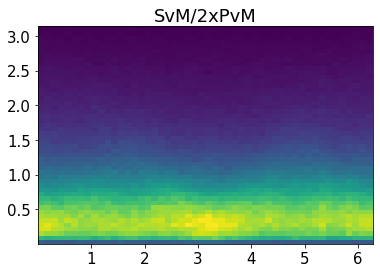

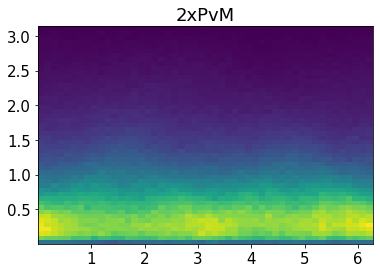

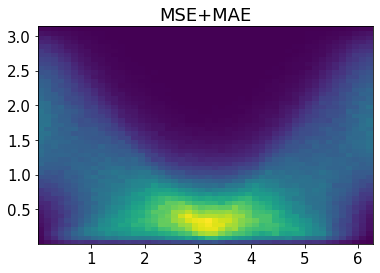

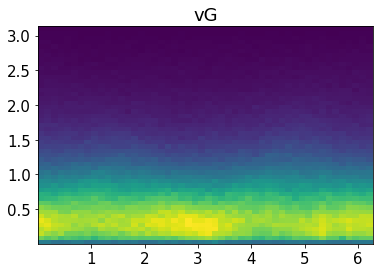

In [134]:
for i in range(len(labels)):
    fig, ax = plt.subplots()
    ax.hist2d(df_truth.azimuth,df_dict[labels[i]].solid,bins=50);
    ax.set_title(labels[i])

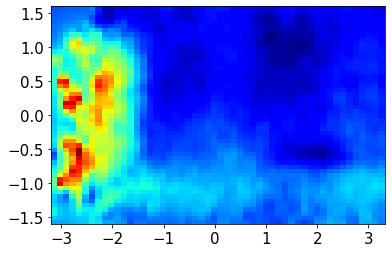

In [128]:
fig, ax = plt.subplots()
ax.pcolormesh(*np.meshgrid((bine(azs)-np.pi),(bine(zes)-np.pi/2)),h[0].T,cmap='jet')

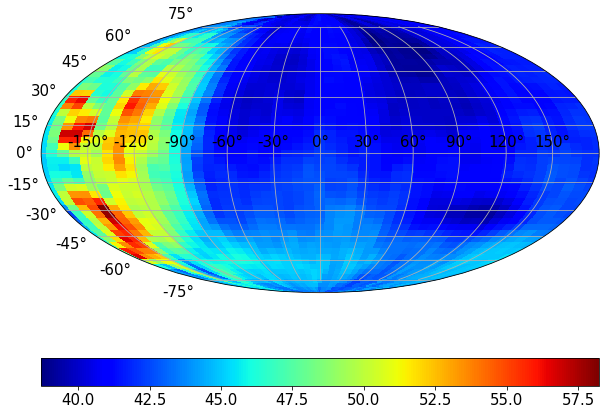

In [137]:
fig, ax = plt.subplots(subplot_kw=dict(projection='mollweide'), figsize=(10,8))
im = ax.pcolormesh(*np.meshgrid((bine(azs)-np.pi),(bine(zes)-np.pi/2)),h[0].T*180/np.pi,cmap='jet')#For example,using as cmap="Spectral",cmap="seismic",cmap="coolwarm" as other alternatives
ax.grid()
fig.colorbar(im, orientation='horizontal');